In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Found 6 classes: ['acai', 'cupuacu', 'graviola', 'guarana', 'pupunha', 'tucuma']


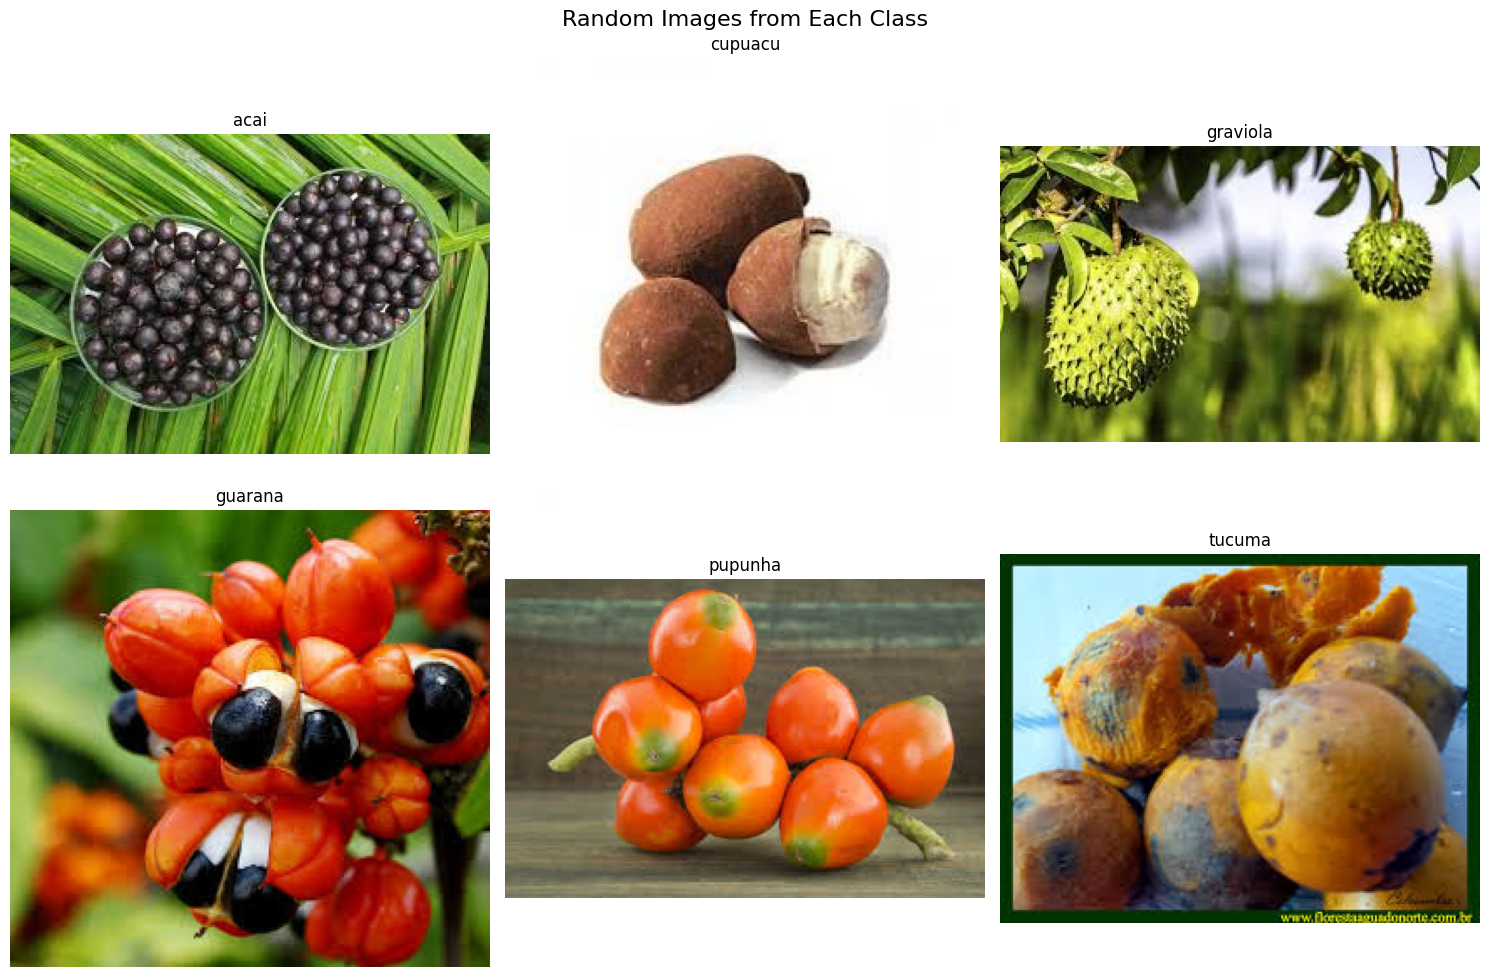

In [3]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Define the train directory path
train_dir = '/content/drive/MyDrive/FruitinAmazon/train'

# Get the list of class directories
class_dirs = [d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]
class_dirs.sort()  # Sort for consistent order
print(f"Found {len(class_dirs)} classes: {class_dirs}")

# Select one random image from each class
images = []
class_names = []
for class_dir in class_dirs:
    class_path = os.path.join(train_dir, class_dir)
    image_files = [f for f in os.listdir(class_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
    if image_files:  # Ensure there’s at least one image
        random_image = random.choice(image_files)
        image_path = os.path.join(class_path, random_image)
        images.append(image_path)
        class_names.append(class_dir)

# Check if we have images to display
if not images:
    raise ValueError("No images found in the dataset!")

# Display images in a 2-row grid
rows = 2
cols = (len(images) + 1) // 2  # Ceiling division to fit all classes
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))  # Adjust figure size as needed
fig.suptitle("Random Images from Each Class", fontsize=16)

# Flatten axes array for easier indexing
axes = axes.flatten()

# Plot each image
for i, (image_path, class_name) in enumerate(zip(images, class_names)):
    img = mpimg.imread(image_path)
    axes[i].imshow(img)
    axes[i].set_title(class_name)
    axes[i].axis('off')  # Hide axes

# Hide any unused subplots (if odd number of classes)
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import numpy as np

# Define dataset paths
train_dir = '/content/drive/MyDrive/FruitinAmazon/train'
test_dir = '/content/drive/MyDrive/FruitinAmazon/test'

# Load datasets
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(128, 128),
    batch_size=16,
    label_mode='categorical',
    shuffle=True
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(128, 128),
    batch_size=16,
    label_mode='categorical',
    shuffle=False
)

# Store the number of classes before mapping
num_classes = len(train_dataset.class_names)

# Normalize images
def normalize_img(image, label):
    return tf.cast(image, tf.float32) / 255.0, label

train_dataset = train_dataset.map(normalize_img)
test_dataset = test_dataset.map(normalize_img)

# Define CNN model
model = keras.Sequential([
    keras.Input(shape=(128, 128, 3)),
    layers.Conv2D(32, (3, 3), padding='same', strides=1, activation="relu"),  # Conv1
    layers.MaxPooling2D((2, 2), strides=2),                            # Pool1
    layers.Conv2D(32, (3, 3), padding='same', strides=1, activation="relu"),  # Conv2
    layers.MaxPooling2D((2, 2), strides=2),                            # Pool2
    layers.Flatten(),                                                  # Flatten
    layers.Dense(64, activation="relu"),                               # Hidden 1
    layers.Dense(128, activation="relu"),                              # Hidden 2
    layers.Dense(num_classes, activation="softmax")                    # Output (6)
])

model.summary()

# Compile model
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

checkpoint = ModelCheckpoint(
    'best_model.keras',  # Save best model
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=20,  # Stop after 20 epochs with no improvement
    mode='max',
    verbose=1
)

# Train model
histroy = model.fit(
    train_dataset,
    epochs=250,
    validation_data=test_dataset,
    callbacks=[checkpoint, early_stopping]
)

# Evaluate model
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.4f}")

# Make predictions on one batch
for images, labels in test_dataset.take(1):
    predictions = model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)
    actual_labels = np.argmax(labels, axis=1)
    print("Predicted labels:", predicted_labels[:5])
    print("Actual labels: ", actual_labels[:5])
    break

Found 90 files belonging to 6 classes.
Found 30 files belonging to 6 classes.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       2,097,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,116,454 (8.07 MB)

 Trainable params: 2,116,454 (8.07 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/250
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.1894 - loss: 2.2410
Epoch 1: val_accuracy improved from -inf to 0.16667, saving model to best_model.keras
6/6 ━━━━━━━━━━━━━━━━━━━━ 27s 4s/step - accuracy: 0.1909 - loss: 2.2278 - val_accuracy: 0.1667 - val_loss: 1.7708
Epoch 2/250
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.3008 - loss: 1.7074
Epoch 2: val_accuracy improved from 0.16667 to 0.40000, saving model to best_model.keras
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 489ms/step - accuracy: 0.3086 - loss: 1.7001 - val_accuracy: 0.4000 - val_loss: 1.4482
Epoch 3/250
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - accuracy: 0.3273 - loss: 1.4291
Epoch 3: val_accuracy improved from 0.40000 to 0.50000, saving model to best_model.keras
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 385ms/step - accuracy: 0.3313 - loss: 1.4210 - val_accuracy: 0.5000 - val_loss: 1.2199
Epoch 4/250
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - accuracy: 0.6041 - loss: 1.1176
Epoch 4: val_accuracy improved from 0.50000 to 0.53333, 

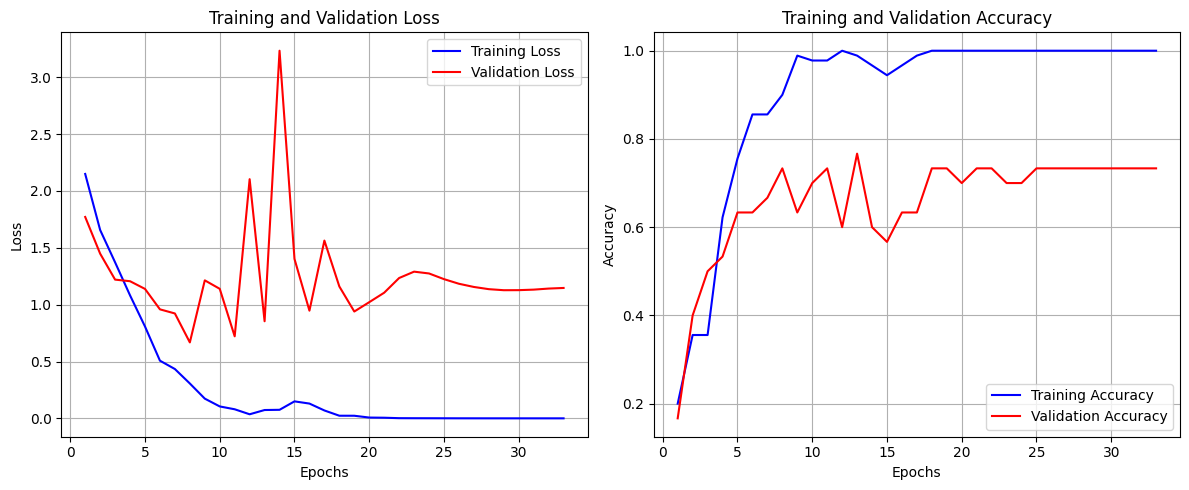

In [6]:
history_dict = histroy.history
epochs = range(1, len(history_dict['loss']) + 1)
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']
train_acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

# Create subplots: 1 row, 2 columns
plt.figure(figsize=(12, 5))

# Plot 1: Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot 2: Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Adjust layout and display
plt.tight_layout()
plt.show()

In [7]:
model.save('fruitdetection.h5')
loaded_model = keras.models.load_model('fruitdetection.h5')

print('model saved to fruitdetection.h5')
print('model loaded from fruitdetection.h5')

model saved to fruitdetection.h5
model loaded from fruitdetection.h5


In [9]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from sklearn.metrics import classification_report
loaded_model = keras.models.load_model('fruitdetection.h5')
print("Model loaded for predictions")

# Collect all test images and labels
all_images = []
all_labels = []
for images, labels in test_dataset:
    all_images.append(images.numpy())
    all_labels.append(labels.numpy())

# Concatenate batches into single arrays
test_images = np.concatenate(all_images, axis=0)  # Shape: (30, 128, 128, 3)
test_labels_onehot = np.concatenate(all_labels, axis=0)  # Shape: (30, 6)

# Make predictions
predictions = loaded_model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)  # Convert probabilities to class indices
true_labels = np.argmax(test_labels_onehot, axis=1)  # Convert one-hot to class indices

# Get class names from the dataset
class_names = test_dataset

# Generate classification report
report = classification_report(true_labels, predicted_labels)
print("Classification Report:\n", report)

Model loaded for predictions
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 955ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.50      0.60      0.55         5
           2       0.71      1.00      0.83         5
           3       0.80      0.80      0.80         5
           4       0.80      0.80      0.80         5
           5       1.00      0.40      0.57         5

    accuracy                           0.73        30
   macro avg       0.77      0.73      0.73        30
weighted avg       0.77      0.73      0.73        30

